In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths()
plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

In [2]:
cmax = 50

JG075B = (
    QuantStudio(rslt_pth / 'JG075B L-MMMMx blocker tripartite competition separate.xlsx', 'JG075B')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('FAM')
)

# Denote reaction conditions
JG075B.reactions.wide = (
    JG075B.reactions.wide
    .replace(
        {'Target': {
            'S075_WTFAM': 'S075_WT',
            'S075_WTHEX': 'S075_WT',
            'S075_SNVFAM': 'S075_SNV',
            'S075_SNVHEX': 'S075_SNV',
        }
        })
    .merge(pd.read_csv(base_pth / 'Experimental' / 'JG075B Plate Map.csv'))#[['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
    .replace({'lg10_Blocker': {-np.inf: -2}})
    .drop(columns=['CT'])
)


JG075B.reactions.neaten()
JG075B.extract_endpoints(cmax=cmax)
endpoints = JG075B.endpoints
JG075B.reactions

/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,Reaction,Blocker,Blocker μM,Configuration,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,1,-0.001097,0.003485
1,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,2,-0.000667,0.002776
2,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,3,0.002053,0.000296
3,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,4,0.002595,-0.000500
4,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,5,0.000969,0.000382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,86,1.660020,1.235080
44636,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,87,1.694048,1.261684
44637,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,88,1.717209,1.278983
44638,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,89,1.735487,1.292101


In [3]:
target_palette = list(zip(['S075_WT','S075_SNV'],['Purples','Greens']))

In [ ]:
hue = 'lg10_Blocker'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
#         (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='lg10_Copies', row='Configuration', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None,
                    height=3, aspect=1.0, linewidth=4,
                    row_order = JG075B.reactions.data['lg10_Copies'].unique()[::-1],
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.refline(y=0.1, color='k', linestyle=':')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

#     can.utils.savefig(f'JG075B Amplification curves by configuration - {target}', path=fig_pth)

Saving..Done
Saving..Done


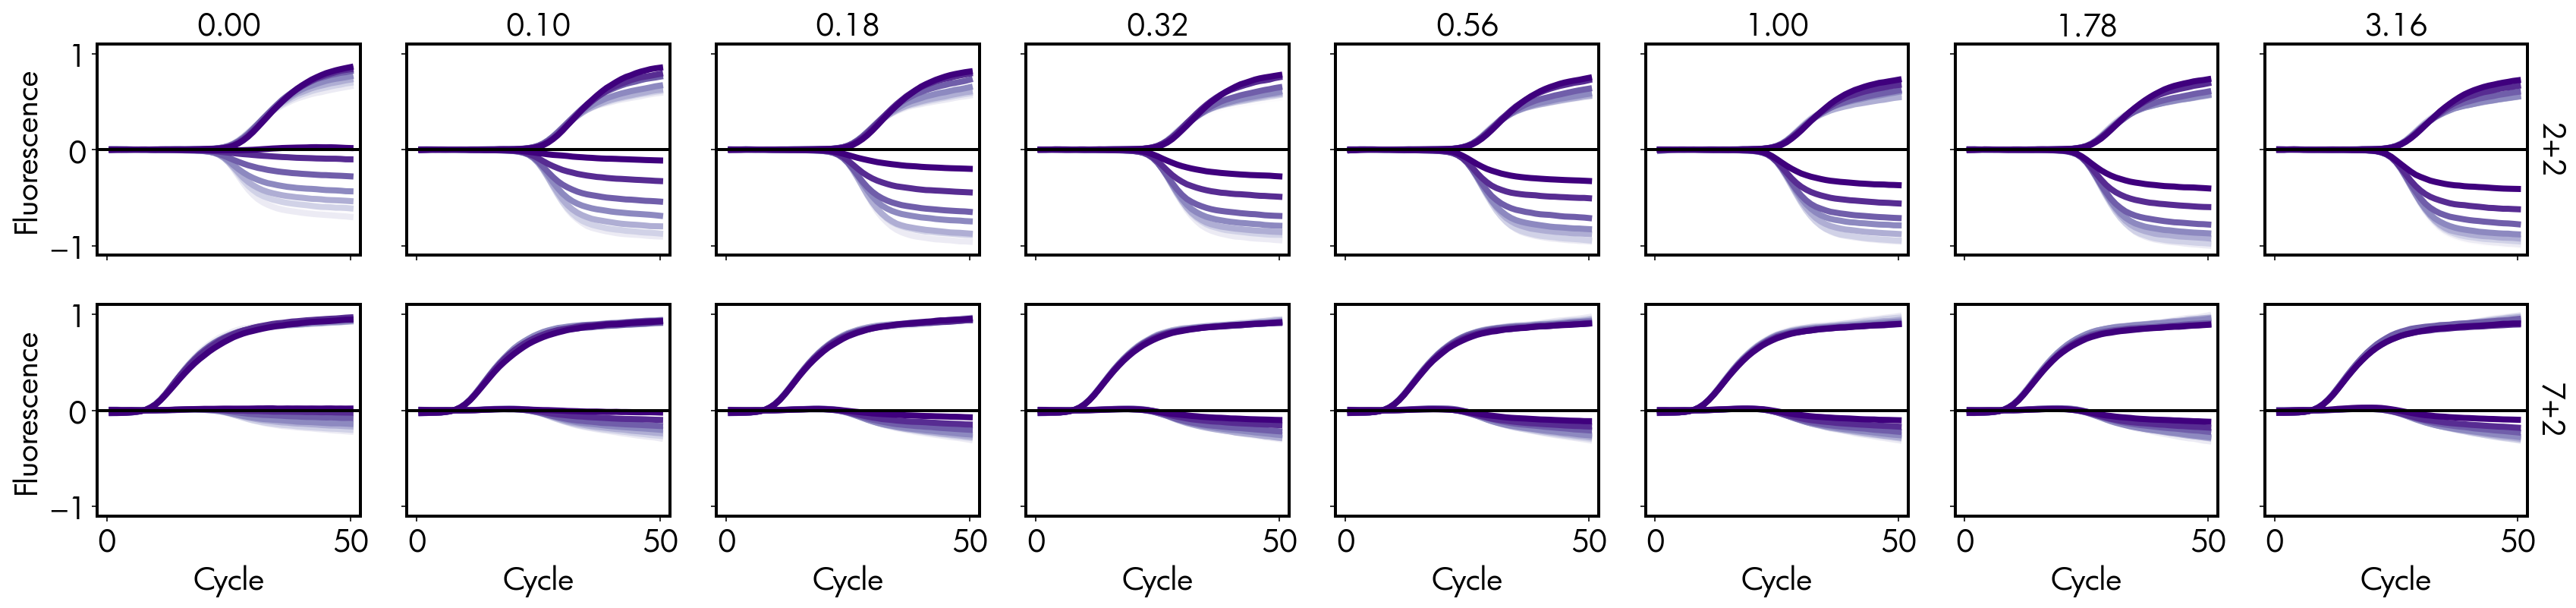

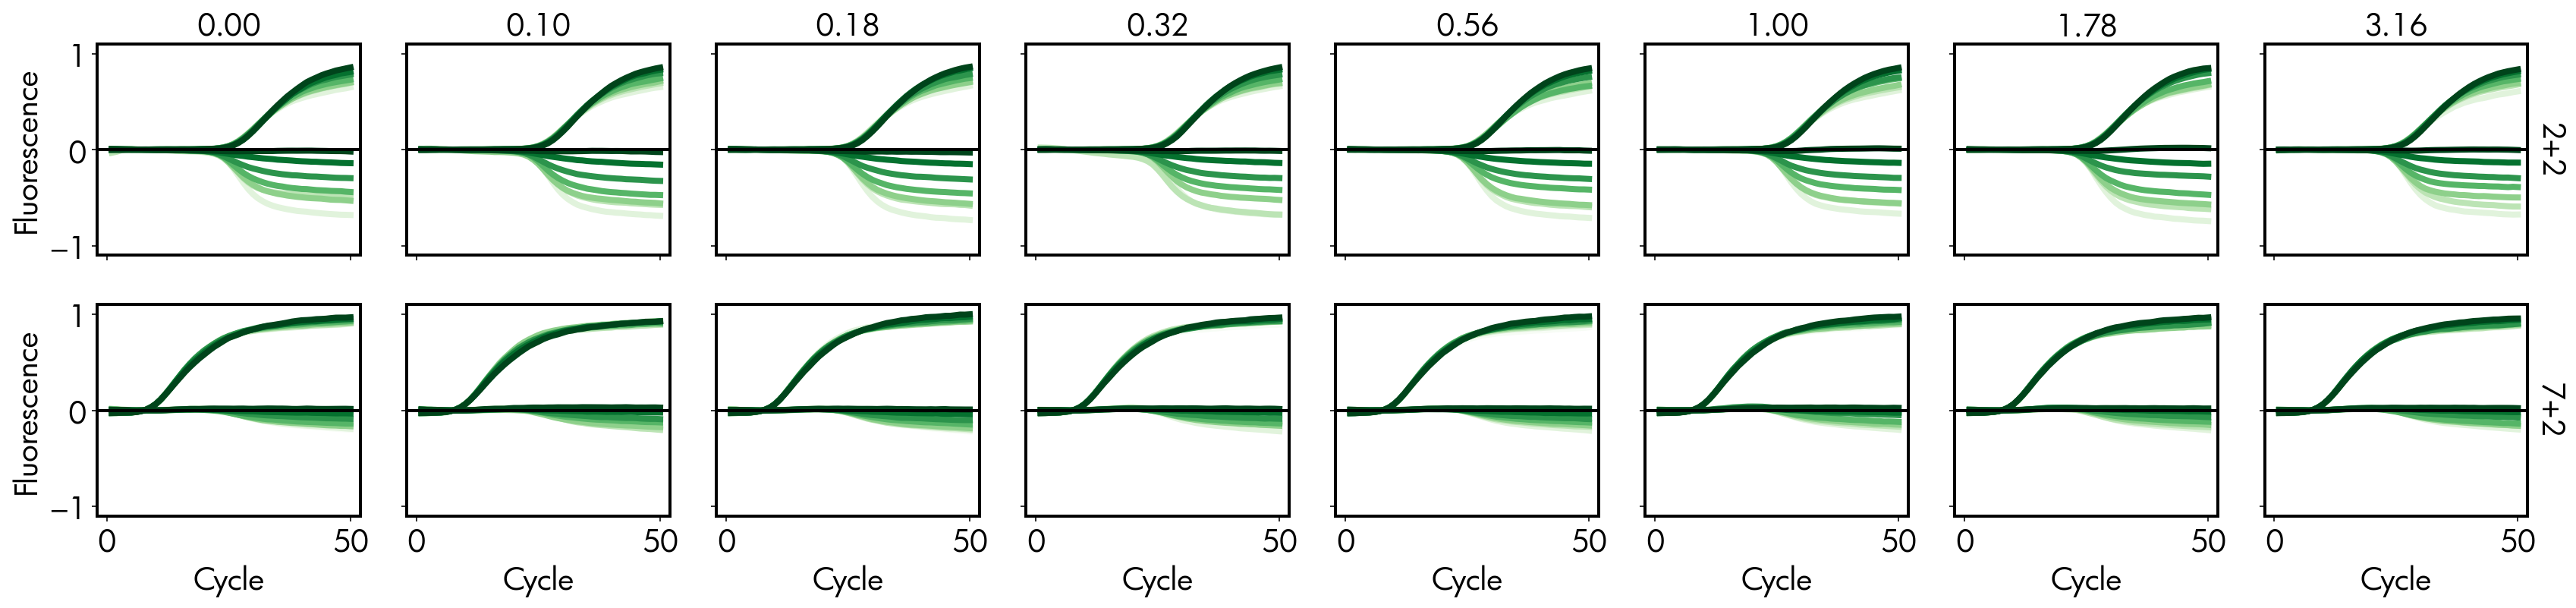

In [5]:
hue = 'lg10_Copies'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

blocker = 'L-MMMMx'
configs = ['2+2','7+2']

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
        (data.Cycle<=cmax) &
#         (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='Blocker μM', row='Configuration', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                    height=3, aspect=1.0, linewidth=4,
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

    can.utils.savefig(f'JG075B L-MMMx Amplification curves by configuration - {target}', path=fig_pth)

In [6]:
ds = gmb.DataSet(JG075B.endpoints, outputs=['SignalDifference'])
gp = gmb.GP(ds).fit(continuous_dims = ['lg10_Copies', 'Blocker μM'],
                    categorical_dims=['Configuration', 'Target'])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Saving..Done


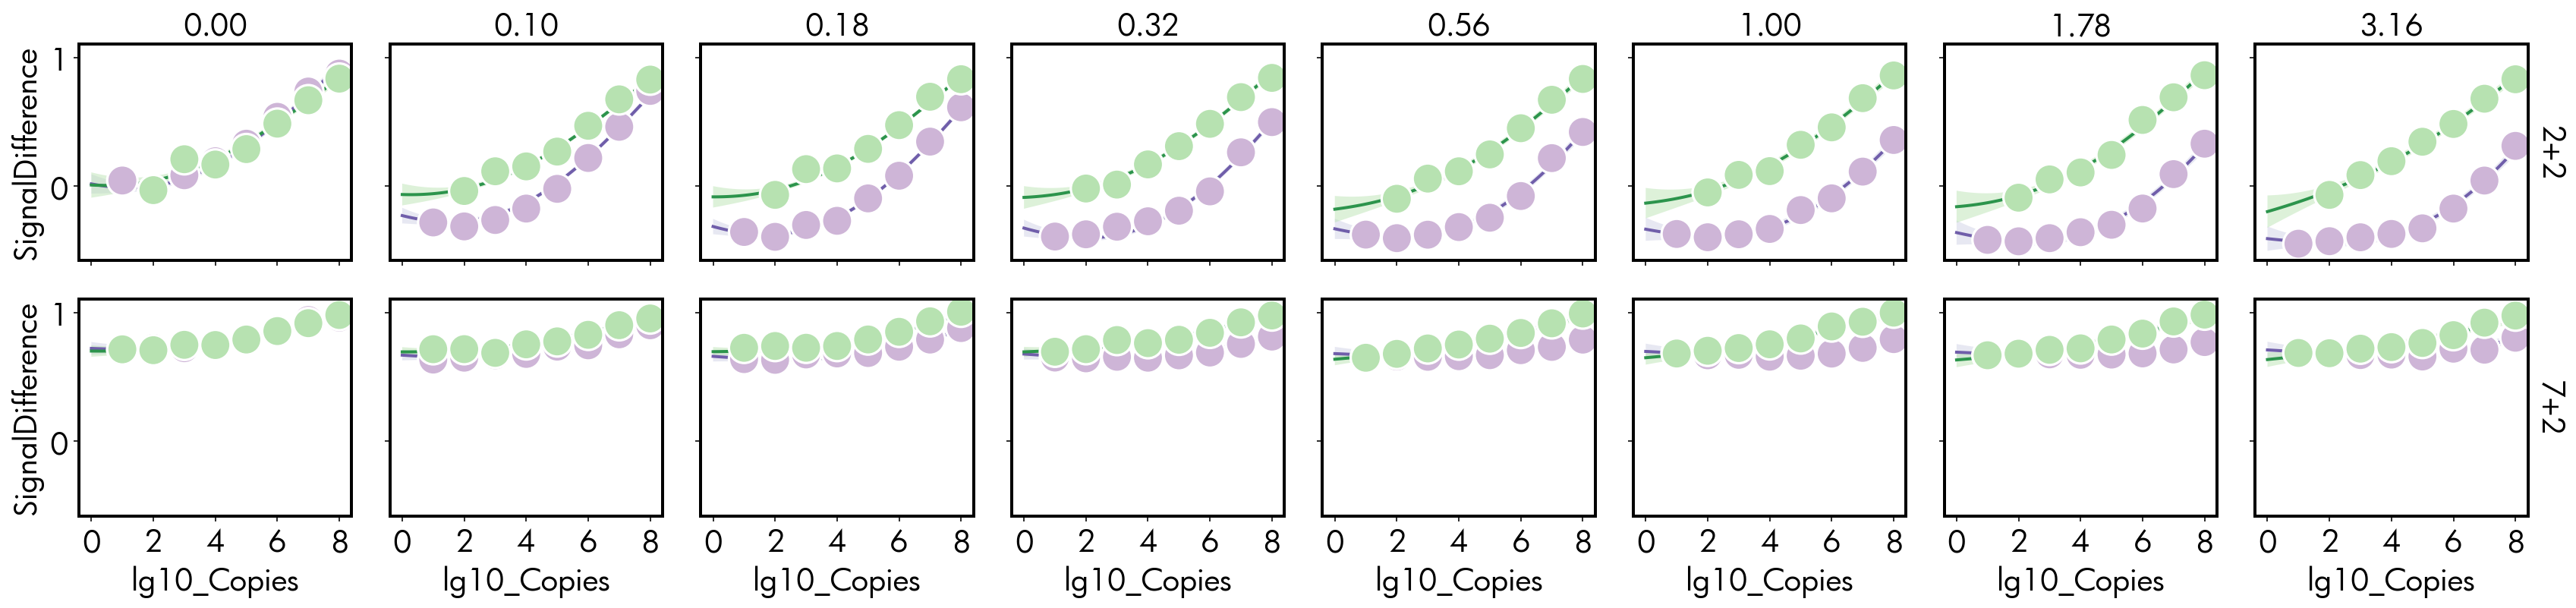

In [7]:
hue = 'SignalDifference'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)

g = sns.relplot(data = endpoints,
                x='lg10_Copies', y='SignalDifference', 
                col='Blocker μM', row='Configuration',
                hue = 'Target', legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.0, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for (row_val, col_val), ax in g.axes_dict.items():
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(lg10_Copies=[0,8])
    X = gp.prepare_grid(at=at, limits=limits)['lg10_Copies']
    WT_sig = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Configuration': row_val}, with_noise=False)
    SNV_sig = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Configuration': row_val}, with_noise=False)
    
    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette='Greens')
    
# g.set(ylabel='')
    
# fig = plt.gcf()
# multicolor_ylabel(fig,('WT Signal',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();

can.utils.savefig(f'JG075B L-MMMx Differential signal response by configuration', path=fig_pth)

Saving..Done
Saving..Done


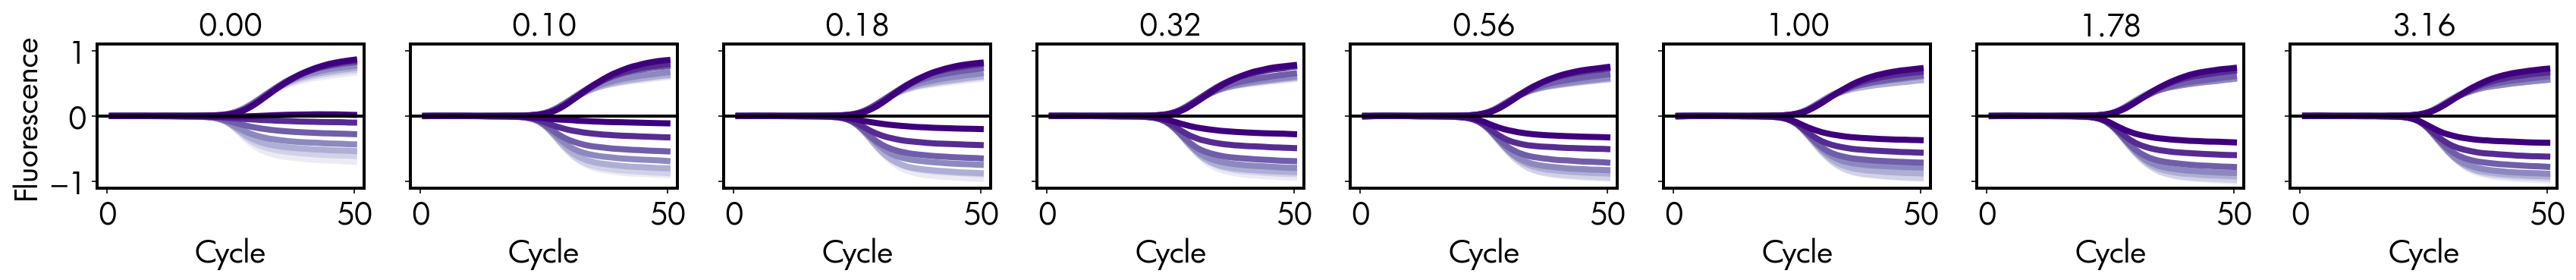

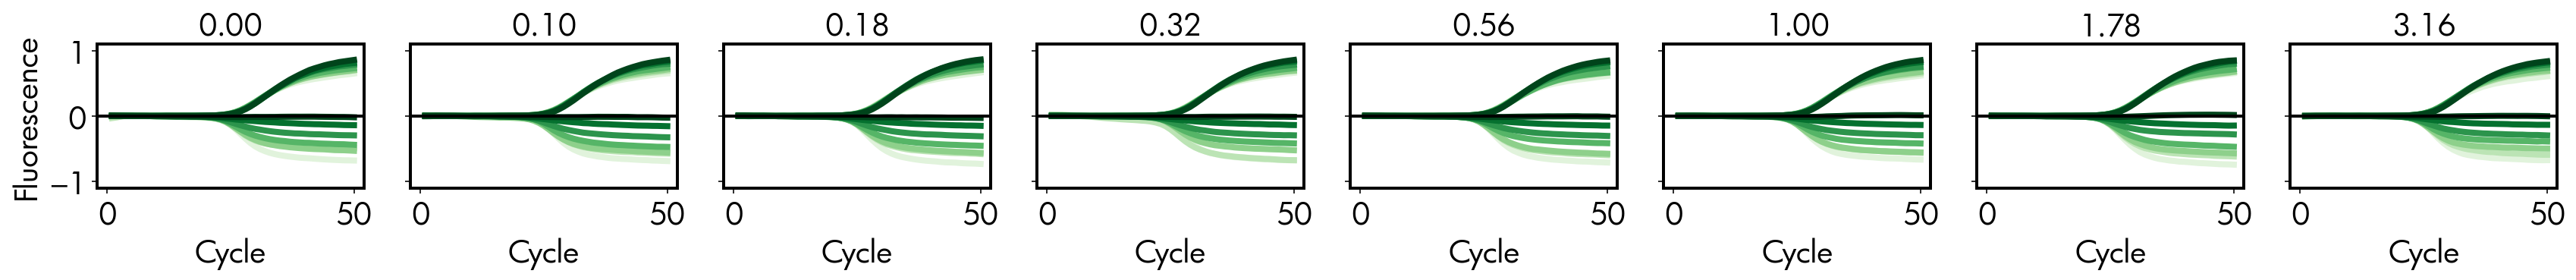

In [15]:
hue = 'lg10_Copies'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

blocker = 'L-MMMMx'
configs = ['2+2','7+2']

config = '2+2'

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
        (data.Cycle<=cmax) &
        (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='Blocker μM', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                    height=3, aspect=1.0, linewidth=4,
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

    can.utils.savefig(f'JG075B L-MMMx Amplification curves by configuration - {target}', path=fig_pth)

Saving..Done


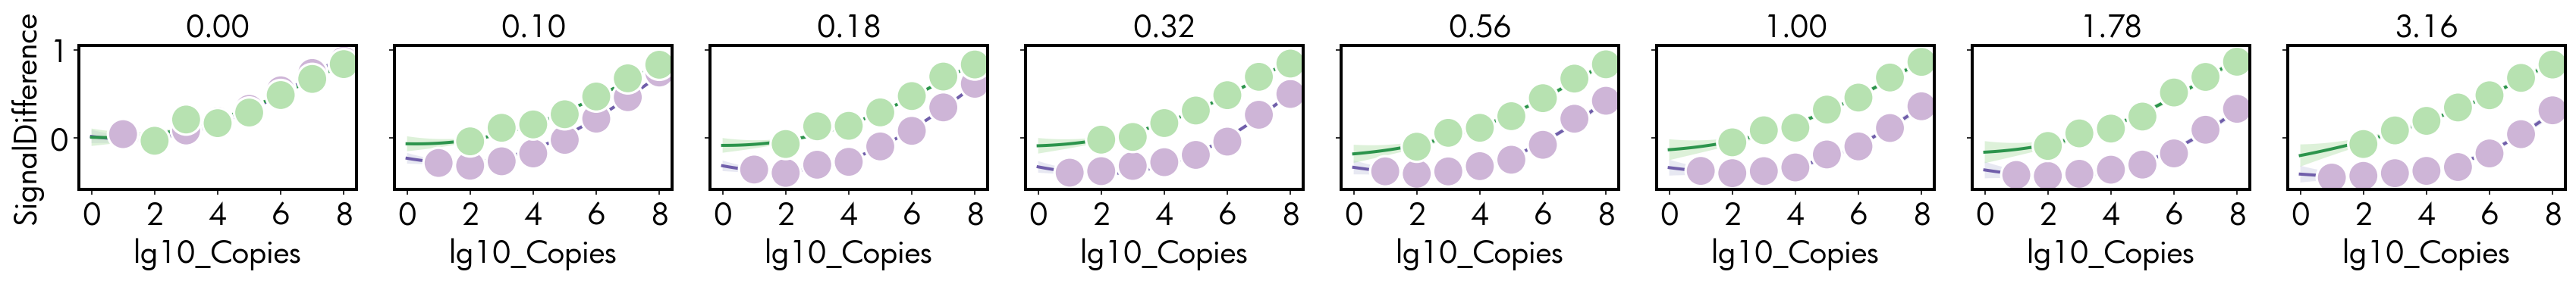

In [16]:
hue = 'SignalDifference'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)

g = sns.relplot(data = endpoints[endpoints.Configuration==config],
                x='lg10_Copies', y='SignalDifference', 
                col='Blocker μM', #row='Configuration',
                hue = 'Target', legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.0, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for (col_val), ax in g.axes_dict.items():
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(lg10_Copies=[0,8])
    X = gp.prepare_grid(at=at, limits=limits)['lg10_Copies']
    WT_sig = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Configuration': '2+2'}, with_noise=False)
    SNV_sig = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Configuration': '2+2'}, with_noise=False)
    
    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette='Greens')
    
# g.set(ylabel='')
    
# fig = plt.gcf()
# multicolor_ylabel(fig,('WT Signal',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();

can.utils.savefig(f'JG075B L-MMMx Differential signal response by configuration', path=fig_pth)